In [158]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gp
from geopandas import GeoDataFrame
from shapely.geometry import LineString
from shapely.geometry import MultiPoint
import shapely
import networkx as nx
import os.path
from os import path
import pathlib
import pandas as pd
from datetime import datetime
import numpy as np

import geopy.distance


from OSMPythonTools.api import Api as osm_api
ox.config(log_console=True, use_cache=True)

In [140]:
!pip install geopy

     |████████████████████████████████| 111 kB 2.0 MB/s eta 0:00:01


In [2]:
# Isochrone Maxspeed

In [3]:
start_point = (52.5153, 13.4040)
dist = 10000

G = ox.graph.graph_from_point(start_point, dist=dist, dist_type='network', network_type='drive')
#, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)

In [19]:
speed_df = pd.read_csv('../data/Uber_speeds/movement-speeds-hourly-berlin-2020-1.csv')

In [20]:
#speed_df = speed_df[speed_df['osm_way_id'] == 28496022]
speed_df = speed_df.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).min()['speed_kph_mean'].reset_index()

#speed_df['weekday'] = [datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.000Z').weekday() for time in speed_df['utc_timestamp']]
#speed_df = speed_df[is_weekday]




#plt.plot(speed_df.groupby(['hour']).mean()['speed_kph_mean'])
speed_df

,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean
0,4045243,307495922,3155500679,12.542
1,4045243,1822620447,307495922,14.474
2,4045656,21441709,30432575,44.851
3,4045656,21441714,561503519,43.189
4,4045656,30432116,21441714,21.569
...,...,...,...,...
26651,699073594,4548431293,2060277874,47.576
26652,699211935,1799364311,6565966749,27.526
26653,699217505,268224213,1769691978,41.231
26654,699295574,248079015,152428728,30.826


In [31]:
for way in speed_df.iloc():
    node_ids = [int(way['osm_start_node_id']),int(way['osm_end_node_id'])]
    try:
        G.edges[min(node_ids),max(node_ids),0]['real_speed'] = way['speed_kph_mean']
    except:
        pass


In [35]:
G.edges[172564, 21509247, 0]

{'osmid': 27606741,
 'oneway': True,
 'lanes': '2',
 'name': 'Kurt-Schumacher-Platz',
 'highway': 'secondary',
 'maxspeed': '50',
 'length': 17.296,
 'time': 0.020755199999999998,
 'real_time': 0.6294948318532537,
 'real_speed': 27.476}

In [69]:
failed_counter = 0
for u, v, k, data in G.edges(data=True, keys=True):
    if ('maxspeed' in data.keys()):
        if(type(data['maxspeed']) == list):
            speed = min(data['maxspeed'])
        else:
            speed = data['maxspeed']
    else:
        speed = 50.0
        
    if (speed == 'DE:urban'):
        speed = 50.0

    data['time'] = data['length'] / (float(speed) * 1000 / 60)

    
    
    if ('real_speed' in data.keys()):
        real_speed = float(data['real_speed'])
        #print(real_speed / float(speed))
    else:
        real_speed = speed
        
    data['real_time'] = data['length'] / (float(real_speed)* 1000 / 60)

In [37]:
nodes, edges = ox.graph_to_gdfs(G)
edges['real_time'].describe()

count    28198.000000
mean         0.411007
std          0.689039
min          0.002050
25%          0.124722
50%          0.246900
75%          0.460619
max         28.099272
Name: real_time, dtype: float64

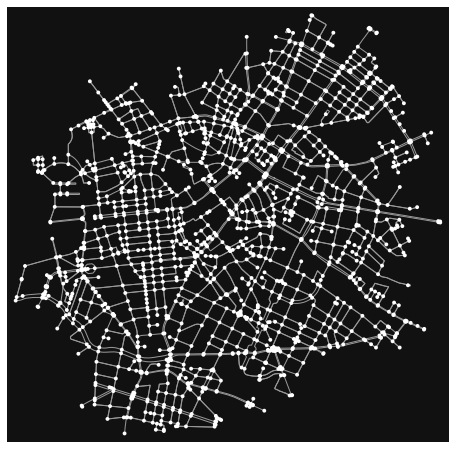

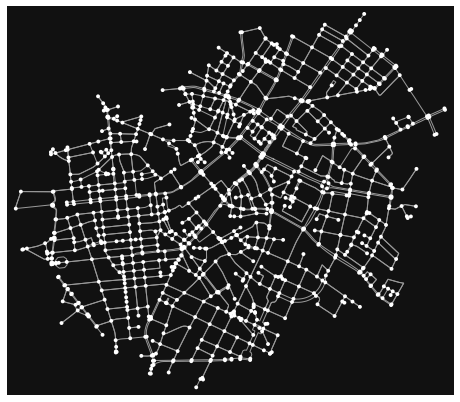

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [136]:
center_node = ox.get_nearest_node(G, start_point)

subgraph_15 = nx.ego_graph(G, center_node, radius=5, distance='time')
subgraph_15_real = nx.ego_graph(G, center_node, radius=5, distance='real_time')

ox.plot_graph(subgraph_15)
ox.plot_graph(subgraph_15_real)



In [157]:
nodes, edges = ox.graph_to_gdfs(subgraph_15_real)

lat, long = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy

#nodes['geometry'].plot()
#zip(lat,long)[0]

#MultiPoint(nodes.reset_index()['geometry']).convex_hull
    
dist = [geopy.distance.geodesic(point,start_point).meters for point in zip(long,lat)]
np.mean(dist)

NameError: name 'np' is not defined

In [33]:
nodes, edges = ox.graph_to_gdfs()
edges = edges.sort_values('time')
nodes

,y,x,osmid,highway,geometry
282404879,52.478526,13.625652,282404879,NaN,POINT (13.62565 52.47853)
282404882,52.480165,13.627926,282404882,NaN,POINT (13.62793 52.48017)
286021652,52.480332,13.604946,286021652,NaN,POINT (13.60495 52.48033)
247148569,52.481581,13.587064,247148569,NaN,POINT (13.58706 52.48158)
34678811,52.478125,13.568680,34678811,NaN,POINT (13.56868 52.47812)
...,...,...,...,...,...
274638802,52.456124,13.592323,274638802,NaN,POINT (13.59232 52.45612)
274638808,52.461162,13.573655,274638808,NaN,POINT (13.57365 52.46116)
370882529,52.450853,13.572071,370882529,NaN,POINT (13.57207 52.45085)
281532394,52.463592,13.596067,281532394,NaN,POINT (13.59607 52.46359)
